In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
import time

from math import *

In [26]:
W=2*np.pi
T=(2*np.pi)/W
n=50
L=n*T

N_grid=10000
t=np.linspace(0,L,N_grid)
h=t[1]-t[0]
p=int(round(T/h))

d=0.25
dd=-0.2

dw_samples=np.linspace(0.05, 0.125, 50)

In [27]:
dual_border=[]
for dw in dw_samples:
    left=1
    if dw==0.05:
        right=N_grid-2*p-1
    else:
        right=dual_border[-1]
 
    start = time.time()
    while (right-left>1):
        s=round((left+right)/2)

        k0=np.array([d]*N_grid)
        k0[2*p:2*p+s]=d+dd
        k0_f=interpolate.interp1d(t, k0, bounds_error=False, fill_value="extrapolate")

        f=lambda t, x: 2*dw-k0_f(t)*sin(x)

        init=np.arcsin(2*dw/k0[0])

        theta=[0]*N_grid
        for i in range(N_grid):
            if i==0:
                theta[i]=init
            else:
                k1=f(t[i-1], theta[i-1])*h
                k2=f(t[i-1]+h/2, theta[i-1]+k1/2)*h
                k3=f(t[i-1]+h/2, theta[i-1]+k2/2)*h
                k4=f(t[i-1]+h, theta[i-1]+k3)*h

                theta[i]=theta[i-1]+(k1+2*k2+2*k3+k4)/6

        theta=np.array(theta)
        x0=np.sin(W*t)
        y0=np.sin(W*t+theta)

        C_0=[0]*N_grid
        for i in range(N_grid):
            if (t[i]-T/2>=0) and (t[i]+T/2<=L):
                C_0[i]=np.corrcoef(x0[i-int(p/2):i+int(p/2)], y0[i-int(p/2):i+int(p/2)])[0][1]
            else:
                C_0[i]=nan

        phi0=np.arccos(C_0)
        k_hat=np.divide(np.array([2*dw]*N_grid), np.sin(phi0))

        dmin=argrelextrema(k_hat, np.less)
        n_min=dmin[0].shape[0]
        extr=[]

        eps=0.001

        for i in range(n_min):
            if ((((i==0) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i+1]]))
                or ((i==n_min-1) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i-1]]))
                or ((k_hat[dmin[0][i]]<k_hat[dmin[0][i-1]]) and (k_hat[dmin[0][i]]<k_hat[dmin[0][i+1]])))
                and (dmin[0][i]>2*p) and (abs(k_hat[dmin[0][i]]-d)>eps)):
                    extr.append(dmin[0][i])

        dk=np.diff(k_hat)/h
        dk=np.nan_to_num(dk)
        
        if (max(dk)>15) or ((len(extr)>1) and (extr[0]<=2*p+s) and (extr[1]>2*p+s)):
            right=s
        else:
            left=s

    stop = time.time()        
    print('-----: ', stop-start, left, ' ---- ', dw, ' ----- ', len(extr))
    dual_border.append(left)
    
np.savetxt('PT1409_50_10000_extr2_cor025.out', dual_border, delimiter=',')

/usr/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


-----:  74.85302376747131 4064  ----  0.05  -----  2
-----:  70.5251407623291 3790  ----  0.0515306122449  -----  2
-----:  68.8908920288086 3581  ----  0.0530612244898  -----  2
-----:  70.0130045413971 3384  ----  0.0545918367347  -----  2
-----:  68.46812462806702 3252  ----  0.0561224489796  -----  2
-----:  68.31354904174805 3050  ----  0.0576530612245  -----  2
-----:  62.57958650588989 2946  ----  0.0591836734694  -----  1
-----:  68.36086440086365 2744  ----  0.0607142857143  -----  2
-----:  79.97845792770386 2640  ----  0.0622448979592  -----  2
-----:  72.54945158958435 2537  ----  0.0637755102041  -----  2
-----:  80.8644232749939 2434  ----  0.065306122449  -----  2
-----:  69.26336884498596 2331  ----  0.0668367346939  -----  1
-----:  75.2696361541748 2228  ----  0.0683673469388  -----  2
-----:  72.72729516029358 2125  ----  0.0698979591837  -----  1
-----:  80.33151268959045 2022  ----  0.0714285714286  -----  2
-----:  76.81979632377625 1919  ----  0.0729591836735  --

In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    from math import factorial
    
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [8]:
dw_samples=np.linspace(0.05, 1.25, 200)
dual_border=np.fromfile(file='PT2407_50_20000_extr2.out', sep='\n')
dual_border_sm=savitzky_golay(dual_border, 51, 3)

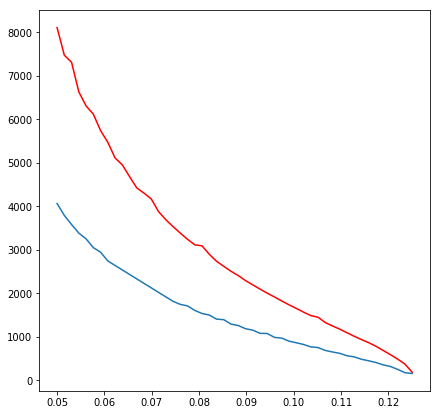

In [29]:
plt.figure(figsize=(7,7))
plt.plot(dw_samples, dual_border)
dual_border2=np.fromfile(file='PT1409_50_10000_extr_break_fast_long_025.out', sep='\n')
plt.plot(dw_samples, dual_border2, 'r')
plt.show()

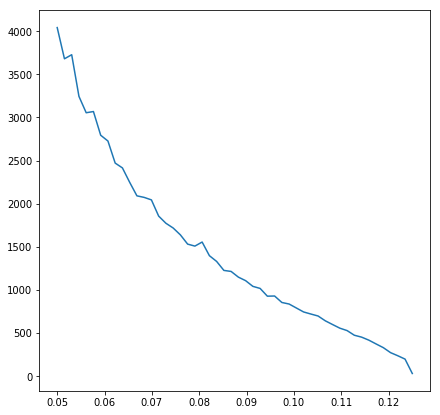

In [31]:
plt.figure(figsize=(7,7))
plt.plot(dw_samples, dual_border2-dual_border)
plt.show()